In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb  5 19:33:37 2023

@author: vidura
"""
#%% LIB

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import matplotlib.pyplot as plt
import math

from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import InPort, OutPort


# In[2]:

#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
import matplotlib.pyplot as plt
import math


# In[ ]:


'''
Find gradient of a [x], [y] data paired 2 lists
'''
import random
def find_gradient(x, y):
    if (len(x) != len(y)):
        assert("Dimensions does not match")
    lst_size = len(x)
    gradients = {}
    for i in range(1, lst_size-1):
        m1 = 0
        m2 = 0
        rnd_int = i
        x1 = x[rnd_int]
        x2 = x[rnd_int + 1]
        x3 = x[rnd_int - 1]
        m1 = (y[rnd_int + 1] - y[rnd_int])     / (x2 - x1)
        m2 = (y[rnd_int    ] - y[rnd_int - 1]) / (x1 - x3)
        if (round(m1,2) == round(m2,2)):
            if (m1 > 0):
                gradients[round(m1,2)] = i
    gradients = ({k: v for k, v in sorted(gradients.items(), key=lambda item: item[1])})
    return list(gradients.keys())



# In[ ]:


'''Function to convert polar Z to rect Z
'''
def pol2complex(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return complex(x, y)

'''Function to convert polar [Z] to rect [Z]'''
def phase2complex_array(arr):
    new_arr = [pol2complex(1,x) for x in arr]
    return new_arr

'''Function to convert rect [Z] to polar [Z]
   and clean the angle'''
import cmath
def complexarr2phase(arr):
    phase_arr = [cmath.phase(x) for x in arr]
    for i in range(len(phase_arr)):
        while(phase_arr[i] < 0):
            phase_arr[i] += 2 * cmath.pi
    return phase_arr

'''Function to clean polar [Z] angle'''
def cleanphase(arr):
    for i in range(len(arr)):
        while arr[i] < 0:
            arr[i] += 2 * cmath.pi
        
        while arr[i] > 2*cmath.pi:
            arr[i] -= 2 * cmath.pi
    
    return arr

'''Function to convert Rad [Z] to Degree [Z]'''
def convert_rad2deg(arr, round_val = False):
    if round_val == False:
        return [180 * x / cmath.pi  for x in arr]
    else:
        return [round(180 * x / cmath.pi, 1)  for x in arr]

'''Function to convert Degree [Z] to Rad [Z]'''
def convert_deg2rad(arr, round_val = False):
    if round_val == False:
        return [cmath.pi * x / 180 for x in arr]
    else:
        return [round(cmath.pi * x / 180, 1) for x in arr]

'''Function to place all elements of [vec] on unit circle'''
def normalize_cmplx(vec):
    rslt = [ z/abs(z) for z in vec]
    return rslt


# In[4]:


def show_voltages(title_lst, vec, figsize):
    if len(title_lst) != len(vec):
        assert("Dimensions does not match")
    
    dim = len(vec)
    figure, axis = plt.subplots(dim, figsize=figsize)
    
    
    for i in range(dim):
        title = title_lst[i]
        x = [x for x in range(0, len(vec[i]))]
        axis[i].plot(x, vec[i])
        axis[i].title.set_text(title)
        
    plt.show()                       
    
# def show_gradients(title_lst, vec):
#     vec = np.array(vec)
#     for i in range(len(vec)):
#         grad = find_gradient( [x for x in range(len(vec[i]))], vec[i])
#         print(f'{title[i]} : {grad}')
        


# In[ ]:


'''
Cosine similarity of [v2] relative to [v1]
'''
def similarity(v1, v2):
    if (len(v1) != len(v2)):
        assert("Dimensions do not match!")
    v1_phase = complexarr2phase(v1)
    v2_phase = complexarr2phase(v2)
    error_v = np.array([ math.cos(a-b) 
                        for a, b in zip(v1_phase, v2_phase) ])
    return np.sum(error_v) / len(v1)




# In[3]:


class GlobalVars():
    global_threshold = 10
    global_max = 1000000
    time_steps = global_threshold * 2 + 1


# In[4]:


class FHRR_Encoder(AbstractProcess):
    def __init__(self, vec : [complex]):
        super().__init__()
        hd_vec = complexarr2phase(vec)
        shape = (len(hd_vec),)
        self.spikes_out = OutPort(shape=shape)  # Input spikes to the classifier
        self.input_vec = Var(shape=shape, init=hd_vec)
        self.v = Var(shape=shape, init=0)
        self.vth = Var(shape=(1,), init=GlobalVars.global_threshold)
        
    def get_v(self):
        return self.v.get()

class FHRR_Decoder(AbstractProcess):

    def __init__(self, dimension : int):
        super().__init__()
        dim = dimension
        shape = (dim,)
        self.spikes_a_in = InPort(shape=shape)
        self.v = Var(shape=shape, init=0)
        self.decoded_a = Var(shape=shape, init=0)
        self.vth = Var(shape=(1,), init=GlobalVars.global_threshold)
        
        self.a_last_spk = Var(shape=shape, init=0)
        self.a_period = Var(shape=shape, init=GlobalVars.global_max)
        
    def get_v(self):
        return self.v.get()
    
    def get_decoded_value(self):
        return self.decoded_a.get()
    
class FHRR_Sum(AbstractProcess):

    def __init__(self, dimension : int):
        super().__init__()
        self.dim = Var(shape=(1,), init=dimension)
        shape = (dimension,)
        self.spikes_a_in = InPort(shape=shape)
        self.spikes_b_in = InPort(shape=shape)
        self.spikes_out = OutPort(shape=shape)
        self.v = Var(shape=shape, init=0)
        self.vth = Var(shape=(1,), init=GlobalVars.global_threshold)
        
        self.a_last_spk = Var(shape=shape, init=0)
        self.b_last_spk = Var(shape=shape, init=0)
        self.a_period = Var(shape=shape, init=GlobalVars.global_max)
        self.b_period = Var(shape=shape, init=GlobalVars.global_max)
        self.phase_arr_clean = Var(shape=shape, init=0)
        
    def get_v(self):
        return self.v.get()
    
    def get_phase_arr_clean(self):
        return self.phase_arr_clean.get()
    
class FHRR_Multiply(AbstractProcess):

    def __init__(self, dimension : int):
        super().__init__()
        self.dim = Var(shape=(1,), init=dimension)
        shape = (dimension,)
        self.spikes_a_in = InPort(shape=shape)
        self.spikes_b_in = InPort(shape=shape)
        self.spikes_out = OutPort(shape=shape)
        self.v = Var(shape=shape, init=0)
        self.vth = Var(shape=(1,), init=GlobalVars.global_threshold)
        
        self.a_last_spk = Var(shape=shape, init=0)
        self.b_last_spk = Var(shape=shape, init=0)
        self.a_period = Var(shape=shape, init=GlobalVars.global_max)
        self.b_period = Var(shape=shape, init=GlobalVars.global_max)
        
    def get_v(self):
        return self.v.get()


# In[5]:




@implements(proc=FHRR_Encoder, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeInputModel(PyLoihiProcessModel):
    spikes_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    input_vec: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    v: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    vth: int = LavaPyType(int, int, precision=32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params)
        self.time_step = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        if self.time_step == 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
        self.v = np.zeros(self.v.shape)

    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
        self.v[:] = self.v + self.input_vec
        s_out = self.v > self.vth
        self.v[s_out] = 0  # reset voltage to 0 after a spike
        self.spikes_out.send(s_out)

@implements(proc=FHRR_Sum, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeSumModel(PyLoihiProcessModel):   
    dim: int = LavaPyType(int, int, precision=32)
    spikes_a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool, precision=1)
    spikes_b_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool, precision=1)    
    spikes_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    v: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    vth: int = LavaPyType(int, int, precision=32)
    phase_arr_clean: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    

    a_last_spk: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    b_last_spk: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    a_period: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    b_period: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params)
        self.time_step = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        if self.time_step == 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
#         print("Run Post Management")
        self.v          = np.zeros((self.v.shape))
        self.a_last_spk = np.zeros((self.v.shape))
        self.b_last_spk = np.zeros((self.v.shape))

    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
#         print(f"time : {self.time_step}")
        vec_time_step = np.full((self.v.shape), self.time_step)
        
        new_spike_times = self.spikes_a_in.peek() * vec_time_step 
        new_spikes      = (new_spike_times > 0) * 1
        new_spikes_inv  = 1 - (new_spikes > 0)
        
        masked_last_spike = self.a_last_spk * new_spikes
        self.a_period[:] = (new_spike_times - masked_last_spike) + new_spikes_inv * self.a_period
        
        masked_last_spike_inv = self.a_last_spk * new_spikes_inv
        self.a_last_spk = masked_last_spike_inv + new_spikes * vec_time_step
        
        decoded_a = GlobalVars.global_threshold / self.a_period
        complex_arr_a = phase2complex_array(decoded_a)
        
        ###############################################################################
        
        new_spike_times = self.spikes_b_in.peek() * vec_time_step 
        new_spikes      = (new_spike_times > 0) * 1
        new_spikes_inv  = 1 - (new_spikes > 0)
        
        masked_last_spike = self.b_last_spk * new_spikes
        self.b_period[:] = (new_spike_times - masked_last_spike) + new_spikes_inv * self.b_period
        
        masked_last_spike_inv = self.b_last_spk * new_spikes_inv
        self.b_last_spk = masked_last_spike_inv + new_spikes * vec_time_step
        
        decoded_b = GlobalVars.global_threshold / self.b_period
        complex_arr_b = phase2complex_array(decoded_b)
        
        ##############################################################################################

#         print(f"decoded_a         : {[item * 180 / cmath.pi for item in decoded_a]}")
#         print(f"decoded_b         : {[item * 180 / cmath.pi for item in decoded_b]}")
        
        sum_complex = [a + b for a,b in zip(complex_arr_a, complex_arr_b)]
        
        phase_arr = complexarr2phase(sum_complex)
        self.phase_arr_clean = cleanphase(phase_arr)
        
#         print(f"phase_arr_clean    : {[item * 180 / cmath.pi for item in self.phase_arr_clean]}")
        
        self.v[:] = self.v + self.phase_arr_clean
        s_out = self.v > self.vth
        self.v[s_out] = 0  # reset voltage to 0 after a spike
        self.spikes_out.send(s_out)
        

@implements(proc=FHRR_Multiply, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeMultModel(PyLoihiProcessModel):   
    dim: int = LavaPyType(int, int, precision=32)
    spikes_a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool, precision=1)
    spikes_b_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool, precision=1)    
    spikes_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, bool, precision=1)
    v: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    vth: int = LavaPyType(int, int, precision=32)
    

    a_last_spk: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    b_last_spk: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    a_period: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    b_period: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params)
        self.time_step = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        if self.time_step == 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
        self.v          = np.zeros((self.v.shape))
        self.a_last_spk = np.zeros((self.v.shape))
        self.b_last_spk = np.zeros((self.v.shape))


    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
#         print(f"time : {self.time_step}")
        vec_time_step = np.full((self.v.shape), self.time_step)
        
        new_spike_times = self.spikes_a_in.peek() * vec_time_step 
        new_spikes      = (new_spike_times > 0) * 1
        new_spikes_inv  = 1 - (new_spikes > 0)
        
        masked_last_spike = self.a_last_spk * new_spikes
        self.a_period[:] = (new_spike_times - masked_last_spike) + new_spikes_inv * self.a_period
        

        masked_last_spike_inv = self.a_last_spk * new_spikes_inv
        self.a_last_spk = masked_last_spike_inv + new_spikes * vec_time_step
        
        decoded_a = GlobalVars.global_threshold / self.a_period
        
        ###############################################################################
        
        new_spike_times = self.spikes_b_in.peek() * vec_time_step 
        new_spikes      = (new_spike_times > 0) * 1
        new_spikes_inv  = 1 - (new_spikes > 0)
        
        masked_last_spike = self.b_last_spk * new_spikes
        self.b_period[:] = (new_spike_times - masked_last_spike) + new_spikes_inv * self.b_period
        
        masked_last_spike_inv = self.b_last_spk * new_spikes_inv
        self.b_last_spk = masked_last_spike_inv + new_spikes * vec_time_step
        
        decoded_b = GlobalVars.global_threshold / self.b_period
        
        ##############################################################################################
        
#         print(f"decoded_a         : {[item * 180 / cmath.pi for item in decoded_a]}")
#         print(f"decoded_b         : {[item * 180 / cmath.pi for item in decoded_b]}")
        
        mult_phase = [a + b for a,b in zip(decoded_a, decoded_b)]
        
        mult_phase_cleaned = cleanphase(mult_phase)
        
#         print(f"mult_phase_cleaned         : {[item * 180 / cmath.pi for item in mult_phase_cleaned]}")
        
        self.v[:] = self.v + mult_phase_cleaned
        s_out = self.v > self.vth
        self.v[s_out] = 0
        self.spikes_out.send(s_out)
        


# In[6]:


@implements(proc=FHRR_Decoder, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeDecoderModel(PyLoihiProcessModel):        
    spikes_a_in: PyInPort = LavaPyType(PyInPort.VEC_DENSE, bool, precision=1)
    v: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    decoded_a: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    vth: int = LavaPyType(int, int, precision=32)

    a_last_spk: np.ndarray = LavaPyType(np.ndarray, int, precision=32)
    a_period: np.ndarray = LavaPyType(np.ndarray, float, precision=32)
    
    def __init__(self, proc_params):
        super().__init__(proc_params)
        self.time_step = 0

    def post_guard(self):
        """Guard function for PostManagement phase.
        """
        if self.time_step == GlobalVars.time_steps - 1:
            return True
        return False

    def run_post_mgmt(self):
        """Post-Management phase: executed only when guard function above 
        returns True.
        """
#         print(f"decoded_val  : {[item * 180 / cmath.pi for item in self.decoded_a]}")

    def run_spk(self):
        """Spiking phase: executed unconditionally at every time-step
        """
        
        ###############################################################################
        
        vec_time_step = np.full((self.v.shape), self.time_step)
        
        new_spike_times = self.spikes_a_in.peek() * vec_time_step 
        new_spikes      = (new_spike_times > 0) * 1
        new_spikes_inv  = 1 - (new_spikes > 0)
        
        masked_last_spike = self.a_last_spk * new_spikes
        self.a_period[:] = (new_spike_times - masked_last_spike) + new_spikes_inv * self.a_period
        

        masked_last_spike_inv = self.a_last_spk * new_spikes_inv
        self.a_last_spk = masked_last_spike_inv + new_spikes * vec_time_step
        
        self.decoded_a = GlobalVars.global_threshold / self.a_period
        
#         print(f"decoded_val         : {[item * 180 / cmath.pi for item in self.decoded_a]}")
#         print(f'a_period            : {self.a_period}')
        
        self.v[:] = self.v + self.decoded_a
        s_out = self.v > self.vth
        self.v[s_out] = 0
        


#%%

from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps

class FHRR_SNN_Model():
    
    def __init__(self, dimension, run_loihi=False):
        
        # if (run_loihi):
        #     import lib_FHRR_Loihi as lib
        #     print("Loihi Library Loaded!")
        # else:
        #     import lib_FHRR as lib
        
        self.dimension = dimension
        self.hd1 = np.zeros(dimension)
        self.hd2 = np.zeros(dimension)
        self.n1  = FHRR_Encoder(vec = self.hd1)
        self.n2  = FHRR_Encoder(vec = self.hd2)
        self.add = FHRR_Sum(dimension=dimension)
        self.mul = FHRR_Multiply(dimension=dimension)
        self.decode_mul   = FHRR_Decoder(dimension=dimension)
        self.decode_add   = FHRR_Decoder(dimension=dimension)
        
        self.n1.spikes_out.connect(self.mul.spikes_a_in)
        self.n2.spikes_out.connect(self.mul.spikes_b_in)
        self.mul.spikes_out.connect(self.decode_mul.spikes_a_in)
        
        self.n1.spikes_out.connect(self.add.spikes_a_in)
        self.n2.spikes_out.connect(self.add.spikes_b_in)
        self.add.spikes_out.connect(self.decode_add.spikes_a_in)
        
        self.run_loihi = run_loihi
        self.run_cfg = Loihi2HwCfg()
        
        # if (self.run_loihi):
        #     self.run_cfg = Loihi2HwCfg()
        
        # Just init the runtime 
        self.decode_mul.run(condition=
                            RunSteps(
                                num_steps=1), 
                            run_cfg=self.run_cfg)
        
        self.voltage_n1 = []
        self.voltage_n2 = []
        self.voltage_mult = []
        self.voltage_add  = []
        self.voltage_deco_mult = []
        self.voltage_deco_add = []
    
    '''
    Cosine similarity of [v2] relative to [v1]
    '''
    def similarity(self, v1, v2):
        if (len(v1) != len(v2)):
            assert("Dimensions do not match!")
        v1_phase = complexarr2phase(v1)
        v2_phase = complexarr2phase(v2)
        error_v = np.array([ math.cos(a-b) 
                            for a, b in zip(v1_phase, v2_phase) ])
        return np.sum(error_v) / len(v1)
    
    '''
    Binding using normal binding logic
    '''
    def bind_py(self, v1, v2):
        rslt = [ (a * b) for a, b in zip(v1, v2) ]
        return rslt
    
    def bundle_py(self, v1, v2):
        v1_norm  = normalize_cmplx(v1)
        v2_norm  = normalize_cmplx(v2)
        
        rslt = [ (a + b) for a, b in zip(v1_norm, v2_norm) ]
        return rslt
    
    def run(self, condition, run_cfg, debug=False):

        if (debug == False):
            self.decode_mul.run(condition=condition,run_cfg=run_cfg)
        else:
            for i in range(GlobalVars.time_steps):
                self.voltage_n1.append(self.n1.get_v())
                self.voltage_n2.append(self.n2.get_v())
                self.voltage_mult.append(self.mul.get_v())
                self.voltage_add.append(self.add.get_v())
                self.voltage_deco_mult.append(self.decode_mul.get_v())
                self.voltage_deco_add.append(self.decode_add.get_v())
                self.decode_mul.run(condition=
                            RunSteps(num_steps=1), 
                            run_cfg=self.run_cfg)
                
        return self.voltage_n1, self.voltage_n2, self.voltage_mult, self.voltage_add, self.voltage_deco_mult, self.voltage_deco_add
        
    '''
    Binding using Lava SNN
    '''
    def bind(self, v1, v2, debug = False):
        self.n1.input_vec.set(np.array(complexarr2phase(v1)))
        self.n2.input_vec.set(np.array(complexarr2phase(v2)))
        
        self.n1.v.set(np.zeros(self.dimension))
        self.n2.v.set(np.zeros(self.dimension))
        self.mul.a_last_spk.set(np.zeros(self.dimension))
        self.mul.b_last_spk.set(np.zeros(self.dimension))
        self.mul.a_period.set(np.full((self.mul.a_period.shape), GlobalVars.global_max))
        self.mul.b_period.set(np.full((self.mul.b_period.shape), GlobalVars.global_max))
        
        self.decode_mul.v.set(np.zeros(self.dimension))
        
        voltage_n1, voltage_n2, voltage_mult, voltage_add, voltage_deco_mult, voltage_deco_add = self.run(condition=
                             RunSteps(num_steps=GlobalVars.time_steps),
                             run_cfg=self.run_cfg, debug=debug)
                 
                 
        raw_rslt  = self.decode_mul.get_decoded_value()
        rect_rslt = phase2complex_array(raw_rslt)
        
        return rect_rslt, [voltage_n1, voltage_n2, voltage_mult, voltage_add, voltage_deco_mult, voltage_deco_add]
    
    '''
    Bundle using Lava SNN
    '''
    def bundle(self, v1, v2, debug = False):
        self.n1.input_vec.set(np.array(complexarr2phase(v1)))
        self.n2.input_vec.set(np.array(complexarr2phase(v2)))
        
        self.n1.v.set(np.zeros(self.dimension))
        self.n2.v.set(np.zeros(self.dimension))
        self.add.a_last_spk.set(np.zeros(self.dimension))
        self.add.b_last_spk.set(np.zeros(self.dimension))
        self.add.a_period.set(np.full((self.add.a_period.shape), GlobalVars.global_max))
        self.add.b_period.set(np.full((self.add.b_period.shape), GlobalVars.global_max))
        
        self.decode_add.v.set(np.zeros(self.dimension))
        
        voltage_n1, voltage_n2, voltage_mult, voltage_add, voltage_deco_mult, voltage_deco_add = self.run(condition=
                             RunSteps(num_steps=GlobalVars.time_steps),
                             run_cfg=self.run_cfg, debug=debug)
                 
                 
        raw_rslt  = self.decode_add.get_decoded_value()
        rect_rslt = phase2complex_array(raw_rslt)
        
        return rect_rslt, [voltage_n1, voltage_n2, voltage_mult, voltage_add, voltage_deco_mult, voltage_deco_add]

(1797, 64)
Dimension : 1000
Num of features: 64
(64, 1000)


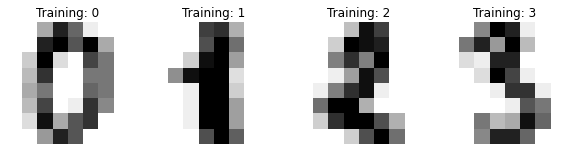

In [2]:
#%%
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

import numpy as np

#%%
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)
    
#%%

# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1)) ## new size (64,)

print(data.shape)

#%%
#### Random project data from 64 to dimension d

d      = 1000
n_feat = data.shape[1]

print(f'Dimension : {d}')
print(f'Num of features: {n_feat}')

np.random.seed(4) ## 4
rnd_project =  2 * np.pi * np.random.rand(n_feat, d) # random angles
rnd_project = 1 * np.exp(1j * rnd_project).real # create a phasor vector


print(rnd_project.shape)
TR_D = np.matmul(data,rnd_project)

TR_D = np.fft.fft(TR_D)

## Normalize each element
for i in range(len(TR_D)):
    for j in range(len(TR_D[i])):
        TR_D[i][j] = TR_D[i][j] / abs(TR_D[i][j] )

In [ ]:
#%%
snn = FHRR_SNN_Model(d)
#%%

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import math, cmath
from tqdm import tqdm

class hdv:
    dim=0
    def __init__(self, dim=0):
        self.dim = dim
        
    def get_rv(self):
        pass
    
    def bind(self, v1, v2):
        pass
    
    def bundle(self, arr_v):
        pass
    
    def similarity(self, v1, v2):
        pass
    
    def set_dim(self, dim):
        self.dim = dim
        
class FHRR(hdv):
    upper = math.pi
    lower = -math.pi
    def get_rv(self):
        angles = np.random.uniform(self.lower, self.upper, self.dim)
        elems = [ cmath.exp(1j*theta) for theta in angles ]
        return np.array(elems)
    
    def bind(self, v1, v2):
        angles_v1 = [cmath.polar(c)[1] for c in v1]
        angles_v2 = [cmath.polar(c)[1] for c in v2]
        sum_rslt =  [ cmath.exp((a1 + a2) * 1j) for a1, a2 in zip(angles_v1, angles_v2) ]
        return np.array(sum_rslt)
    
    def unbind(self, v1, v2):
        angles_v1 = [cmath.polar(c)[1] for c in v1]
        angles_v2 = [cmath.polar(c)[1] for c in v2]
        sum_rslt =  [ cmath.exp((a1 - a2) * 1j) for a1, a2 in zip(angles_v1, angles_v2) ]
        return np.array(sum_rslt)
    
    def bundle_old(self, arr_v):
        rslt = np.zeros(self.dim)
        for v in arr_v:
            rslt = np.add(rslt, v)
        
        rslt_int = [ cmath.exp((cmath.polar(c)[1])*1j) for c in rslt]
        
        return np.array(rslt_int)
    
    def similarity(self, v1, v2):
        angles_v1 = [cmath.polar(c)[1] for c in v1]
        angles_v2 = [cmath.polar(c)[1] for c in v2]
        
        sum_angles = 0
        for i in range(self.dim):
            sum_angles += (cmath.cos(angles_v1[i].real - angles_v2[i].real)).real
            
        return sum_angles / self.dim
   
    '''
    New function to bundle using SNN
    '''
    def bundle(self, arr_v):
        snn_rslt = np.copy(arr_v[0])
        with tqdm(total=len(arr_v)-1) as pbar:
            for i in range(1,len(arr_v)):
                snn_rslt, voltages = snn.bundle(snn_rslt, arr_v[i])
                pbar.update(1)
            
        return snn_rslt

#%%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    TR_D, digits.target, test_size=0.25, shuffle=False)
    
#%%

In [ ]:
fhrr = FHRR(d)

hd_vec = [ [] for i in range(len(digits.target_names)) ]

for i in range(len(X_train)):
    hd_vec[y_train[i]].append(X_train[i])
    
sum_vec = []

with tqdm(total=len(hd_vec)) as pbar:
    for i in range(len(hd_vec)):
        sum_v = fhrr.bundle(hd_vec[i])
        sum_vec.append(sum_v)
        pbar.update(1)
#%%

heat_map = np.zeros((10,10))

for i in range(10):
    for j in range(10):
        heat_map[i][j] = fhrr.similarity(sum_vec[i], sum_vec[j])

import matplotlib.pyplot as plt

plt.imshow(heat_map, cmap='Purples', interpolation='nearest')
plt.show()    

#%%

### Classify

def find_NN(centroids, sample):
    closest = -1
    highest_sim = -1
    for i in range(len(centroids)):
        sim = fhrr.similarity(sample, centroids[i])
        if (sim > highest_sim):
            highest_sim = sim
            closest = i
    
    return closest


print(find_NN(sum_vec, sum_vec[9]))

classification_counts = np.zeros((10,10))

for i in range(len(X_test)):
    classification_counts[y_test[i]][find_NN(sum_vec, X_test[i])] += 1
    

plt.imshow(classification_counts, cmap='Purples', interpolation='nearest')
plt.show()

#%%

## Classification report

predicted = []
for i in range(len(X_test)):
    predicted.append(find_NN(sum_vec, X_test[i]))


print(
    f"Classification report for HD classifier:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)